# Классификация по тональности

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.

In [1]:
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
responses = []

with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in thefile:
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)
    

In [3]:
len(responses)

153499

# Нужно попробовать сократить число отзывов, иначе невозможно выполнить ДЗ

In [4]:
positive_reviews = []
negative_reviews = []
bad_reviews = []
decent_reviews = []
good_reviews = []

for resp in responses:
    if resp['rating_grade'] == 5:
        positive_reviews.append(resp)
    elif resp['rating_grade'] == 1:
        negative_reviews.append(resp)
    elif resp['rating_grade'] == 2:
        bad_reviews.append(resp)
    elif resp['rating_grade'] == 3:
        decent_reviews.append(resp)
    elif resp['rating_grade'] == 4:
        good_reviews.append(resp)

In [5]:
rated_responses = positive_reviews + negative_reviews + bad_reviews + decent_reviews + good_reviews

responses = [response for response in rated_responses if response['city'] is not None]

In [6]:
len(responses)

74710

# Часть 1. Анализ текстов

1. Посчитайте количество отзывов в разных городах и на разные банки


2. Постройте гистограмы длин слов в символах и в словах


3. Найдите 10 самых частых:
    слов
    слов без стоп-слов
    лемм
    существительных
  
  
4. Постройте кривые Ципфа и Хипса


5. Ответьте на следующие вопросы:
    какое слово встречается чаще, "сотрудник" или "клиент"?
    сколько раз встречается слова "мошенничество" и "доверие"?


6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

Посчитайте количество отзывов в разных городах и на разные банки

In [21]:
# Отзывы в разных городах
cities = {}

# Отзывы на разные банки
banks = {}

for review in responses:
    if review['city'] in cities.keys():
        cities[review['city']] += 1
    else:
        cities[review['city']] = 1
    if review['bank_name'] in banks:
        banks[review['bank_name']] += 1
    else:
        banks[review['bank_name']] = 1

In [22]:
sorted(cities.items(), key=lambda item: item[1], reverse=True)

[('г. Москва', 32502),
 ('г. Санкт-Петербург', 8035),
 ('г. Екатеринбург', 1275),
 ('г. Новосибирск', 1148),
 ('г. Нижний Новгород', 1086),
 ('г. Самара', 927),
 ('г. Ростов-на-Дону', 920),
 ('г. Казань', 734),
 ('г. Челябинск', 724),
 ('г. москва', 697),
 ('г. Воронеж', 638),
 ('г. Краснодар', 629),
 ('г. Уфа', 623),
 ('г. Красноярск', 611),
 ('г. Пермь', 585),
 ('г. Волгоград', 510),
 ('г. Саратов', 489),
 ('г. Омск', 447),
 ('г. Калининград', 358),
 ('г. Хабаровск', 352),
 ('г. Иркутск', 332),
 ('г. Тюмень', 322),
 ('г. Ярославль', 321),
 ('г. Владивосток', 319),
 ('г. Тула', 305),
 ('г. Рязань', 301),
 ('г. Томск', 280),
 ('г. Барнаул', 278),
 ('г. Ульяновск', 243),
 ('г. Тверь', 240),
 ('г. Иваново', 239),
 ('г. Ижевск', 234),
 ('г. Липецк', 221),
 ('г. Тольятти', 214),
 ('г. Пенза', 212),
 ('г. Оренбург', 206),
 ('г. Ставрополь', 205),
 ('г. Мурманск', 205),
 ('г. Магнитогорск', 204),
 ('г. Чебоксары', 195),
 ('г. Сочи', 194),
 ('г. Владимир', 191),
 ('г. Мытищи', 189),
 ('г. Бел

In [23]:
sorted(banks.items(), key=lambda item: item[1], reverse=True)

[('Сбербанк России', 14186),
 ('Альфа-Банк', 4442),
 ('ВТБ 24', 3933),
 ('Хоум Кредит Банк', 3822),
 ('Русский Стандарт', 3708),
 ('Национальный Банк «Траст»', 2532),
 ('Тинькофф Банк', 2018),
 ('Связной Банк', 1756),
 ('Московский Кредитный Банк', 1606),
 ('Райффайзенбанк', 1583),
 ('Ренессанс Кредит', 1555),
 ('Промсвязьбанк', 1378),
 ('ЮниКредит Банк', 1338),
 ('ОТП Банк', 1323),
 ('Банк Москвы', 1241),
 ('Ситибанк', 1171),
 ('Ханты-Мансийский банк Открытие', 1146),
 ('Авангард', 1026),
 ('Восточный Экспресс Банк', 989),
 ('МТС Банк', 967),
 ('Росбанк', 860),
 ('БИНБАНК кредитные карты', 836),
 ('Московский Областной Банк', 793),
 ('Бинбанк', 792),
 ('Кредит Европа Банк', 734),
 ('Сетелем Банк', 614),
 ('Уралсиб', 579),
 ('Киви Банк', 568),
 ('Юниаструм Банк', 454),
 ('МДМ Банк', 423),
 ('Совкомбанк', 383),
 ('АйМаниБанк', 382),
 ('2Т Банк', 381),
 ('Русславбанк', 349),
 ('ДельтаКредит', 334),
 ('Современный Коммерческий Банк (бывш. ДжиИ Мани Банк)', 334),
 ('СБ Банк (Судостроительн

2. Постройте гистограмы длин слов в символах и в словах

In [ ]:
# Непонятно, что требуется - как можно построить гистограмму длины слов в словах???

In [9]:
from collections import Counter
from string import punctuation
from nltk.tokenize import word_tokenize

In [10]:
texts = []
for review in responses:
    texts.append(review['text'])

In [11]:
full_corpus = [token for review in texts for token in word_tokenize(review.lower()) if token not in punctuation]

In [108]:
frequency = {}
for word in full_corpus:
    word_len = len(word)
    if frequency.get(word_len, 0) != 0:
        frequency[word_len] += 1
    else:
        frequency[word_len] = 1

<BarContainer object of 110 artists>

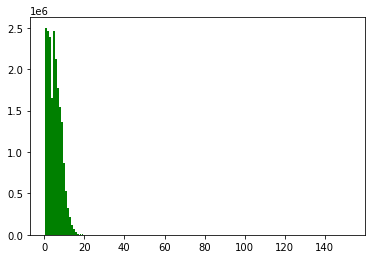

In [111]:
plt.bar(list(frequency.keys()), frequency.values(), color='g') 

3. Найдите 10 самых частых: 

* слов 

* слов без стоп-слов 

* лемм 

* существительных

In [32]:
# Подсчет 10 самых частых слов во всех текстах

full_corpus = [token for review in texts for token in word_tokenize(review.lower()) if token not in punctuation]


In [33]:
freq_dict = Counter(full_corpus)
    
freq_dict.most_common(10)

[('в', 744152),
 ('и', 592263),
 ('не', 471306),
 ('на', 392655),
 ('что', 354840),
 ('я', 321815),
 ('с', 246144),
 ('по', 201009),
 ('мне', 184899),
 ('банка', 146120)]

Подсчет 10 самых частых слов без стоп-слов во всех текстах

In [12]:
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/glebmutovin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stopwords_russian = stopwords.words('russian')

In [14]:
noise = stopwords.words('russian') + list(punctuation) + ['это', '``', "''", '...', '\n', ' ']

In [13]:
full_corpus_stopwords_thrown = [token for i in texts for token in word_tokenize(i.lower())
                                if token not in noise]

freq_dict_1 = Counter(full_corpus_stopwords_thrown)
    
freq_dict_1.most_common(10)

[('банка', 146120),
 ('банк', 103988),
 ('деньги', 72244),
 ('карту', 61359),
 ('карты', 56995),
 ('отделение', 42787),
 ('день', 41949),
 ('заявление', 40610),
 ('кредит', 39464),
 ('время', 38076)]

Подсчет 10 самых частых лемм 

In [15]:
! pip install pymorphy2

You should consider upgrading via the '/Users/glebmutovin/Downloads/ENTER/bin/python -m pip install --upgrade pip' command.


In [16]:
import pymorphy2
m = pymorphy2.MorphAnalyzer()

In [17]:
import re

In [18]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))

def lemmatize(text, mystem=m):
    try:
        return " ".join(m.parse(w)[0].normal_form for w in text.split(' ')).strip()  
    except:
        return " "


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(words_only(text.lower()))

In [19]:
%%time
texts_preprocessed = [preprocess(text) for text in texts]

CPU times: user 30 s, sys: 226 ms, total: 30.2 s
Wall time: 30.2 s


In [20]:
from tqdm import tqdm

In [21]:
# %%time
texts_preprocessed_1 = [lemmatize(text) for text in tqdm(texts_preprocessed) if texts_preprocessed.index(text) < 74710]


100%|██████████| 74710/74710 [22:05<00:00, 56.37it/s]  


In [22]:
full_corpus_lemmas = [text.split(' ') for text in texts_preprocessed_1]

In [23]:
full_corpus_lemmas = [token for review in full_corpus_lemmas for token in review]

In [24]:
full_corpus_lemmas[1:8]

['закрывать', 'вклад', 'отпуск', 'жена', 'заказывать', 'заранее', 'забыть']

In [25]:
freq_dict_2 = Counter(full_corpus_lemmas)
    
freq_dict_2.most_common(10)

[('банк', 363225),
 ('карта', 189965),
 ('деньга', 99900),
 ('день', 99059),
 ('отделение', 92701),
 ('мой', 88064),
 ('сотрудник', 79824),
 ('кредит', 77237),
 ('клиент', 76436),
 ('счёт', 71161)]

Подсчет 10 самых частых существительных во всех текстах

In [89]:
def only_nouns(text, mystem=m):
    try:
        return " ".join(m.parse(w)[0].normal_form for w in text.split(' ') 
                        if 'NOUN' in m.parse(w)[0].tag).strip() 
#     [m.parse(w)[0].normal_form, ms.parse(w)[0].tag) for w in text.split(' ')]
    except:
        return " "


texts_preprocessed_2 = [only_nouns(text) for text in tqdm(texts_preprocessed) if texts_preprocessed.index(text) < 74710]


100%|██████████| 74710/74710 [33:57<00:00, 36.67it/s]


In [90]:
full_corpus_nouns = [text.split(' ') for text in texts_preprocessed_2]

In [91]:
full_corpus_nouns = [token for review in full_corpus_nouns for token in review]

In [92]:
freq_dict_nouns = Counter(full_corpus_nouns)
    
freq_dict_nouns.most_common(10)

[('банк', 363225),
 ('карта', 189965),
 ('деньга', 99900),
 ('день', 99059),
 ('отделение', 92701),
 ('сотрудник', 79824),
 ('кредит', 77237),
 ('клиент', 76436),
 ('счёт', 71161),
 ('заявление', 60719)]

4. Постройте кривые Ципфа и Хипса

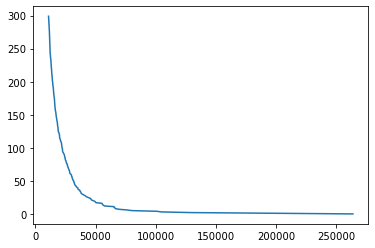

In [25]:
freqs = list(freq_dict_1.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

In [26]:
cnt = Counter()
n_words = []
n_tokens = []

tokens = []
for text in texts:
    tokens = word_tokenize(text)
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

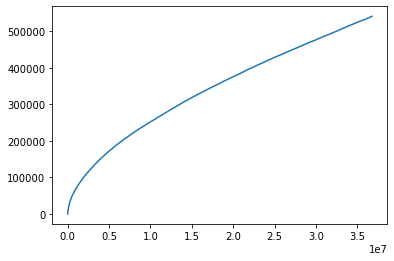

In [27]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

5. Ответьте на следующие вопросы: какое слово встречается чаще, "сотрудник" или "клиент"? сколько раз встречается слова "мошенничество" и "доверие"?


In [9]:
if freq_dict_1['сотрудник'] > freq_dict_1['клиент']:
    print(f'Слово "сотрудник" встречается чаще, чем слово "клиент". Слово "сотрудник" встречается: {freq_dict_1["сотрудник"]}')
else:
    print(f'Слово "клиент" встречается чаще, чем слово "сотрудник". Слово "клиент" встречается: {freq_dict_1["клиент"]}')

Слово "сотрудник" встречается чаще, чем слово "клиент". Слово "сотрудник" встречается: 30994


In [10]:
print(f"Слово мошенничество встречается: {freq_dict_1['мошенничество']} раз;\nСлово доверие встречается: {freq_dict_1['доверие']} раз")

Слово мошенничество встречается: 1102 раз;
Слово доверие встречается: 1153 раз


6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [11]:
from nltk import ngrams

In [116]:
positive_reviews_text = []
negative_reviews_text = []

for resp in responses:
    if resp['rating_grade'] == 5:
        positive_reviews_text.append(resp['text'])
    elif resp['rating_grade'] == 1:
        negative_reviews_text.append(resp['text'])

Поиск биграм

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
# Биграмы для позитивных отзывов
positive_df = pd.DataFrame(positive_reviews_text)
vec_positive = CountVectorizer(ngram_range=(2,2))
bow_positive = vec_positive.fit_transform(positive_df[0])
list(vec_positive.vocabulary_.items())[:10]

[('досрочно закрывали', 273427),
 ('закрывали вклады', 323411),
 ('вклады перед', 137149),
 ('перед отпуском', 746196),
 ('отпуском жена', 715941),
 ('жена заказывала', 305391),
 ('заказывала заранее', 321377),
 ('заранее но', 334158),
 ('но забыла', 613531),
 ('забыла заказать', 314403)]

In [31]:
# Биграмы для негативных отзывов
negative_df = pd.DataFrame(negative_reviews_text)
vec_negative = CountVectorizer(ngram_range=(2,2))
bow_negative = vec_negative.fit_transform(negative_df[0])
list(vec_negative.vocabulary_.items())[:10]

[('открыт вклад', 2008054),
 ('вклад счет', 413173),
 ('счет usd', 3102011),
 ('usd плюс', 147421),
 ('плюс этому', 2173588),
 ('этому есть', 3512588),
 ('есть зарплатная', 843609),
 ('зарплатная карта', 973385),
 ('карта рублях', 1164103),
 ('рублях само', 2747265)]

Поиск ключевых слов 
     


In [124]:
from sklearn.feature_extraction.text import TfidfTransformer

In [118]:
positive_reviews_text_preprocessed = [preprocess(text) for text in tqdm(positive_reviews_text)]

100%|██████████| 10511/10511 [00:03<00:00, 2646.44it/s]


In [120]:
positive_reviews_text_preprocessed = [lemmatize(text) for text in tqdm(positive_reviews_text_preprocessed)]

100%|██████████| 10511/10511 [02:38<00:00, 66.28it/s]


In [190]:
negative_reviews_text_preprocessed = [preprocess(text) for text in tqdm(negative_reviews_text)]

100%|██████████| 39855/39855 [00:18<00:00, 2177.39it/s]


In [191]:
negative_reviews_text_preprocessed = [lemmatize(text) for text in tqdm(negative_reviews_text_preprocessed)]

100%|██████████| 39855/39855 [11:22<00:00, 58.42it/s]


In [189]:
positive_reviews_text_preprocessed_joined = ' '.join(positive_reviews_text_preprocessed)

In [192]:
negative_reviews_text_preprocessed_joined = ' '.join(negative_reviews_text_preprocessed)

In [193]:
pos_neg_reviews_joined = [positive_reviews_text_preprocessed_joined, negative_reviews_text_preprocessed_joined]

In [194]:
pos_neg_list = positive_reviews_text_preprocessed + negative_reviews_text_preprocessed 

In [195]:
cv=CountVectorizer()
word_count_vector=cv.fit_transform(pos_neg_list)

In [196]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [197]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [198]:
feature_names=cv.get_feature_names()
# get the document that we want to extract keywords from
doc=pos_neg_reviews_joined[0]
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,20)
# now print the results
print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


===Keywords===
банк 0.358
карта 0.21
вклад 0.164
очень 0.163
кредит 0.128
клиент 0.115
офис 0.109
сотрудник 0.107
отделение 0.106
год 0.103
спасибо 0.102
день 0.098
работа 0.096
вопрос 0.095
обслуживание 0.095
мой 0.094
деньга 0.094
время 0.091
быстро 0.09
интернет 0.085


In [199]:
feature_names=cv.get_feature_names()

doc=pos_neg_reviews_joined[1]
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

keywords=extract_topn_from_vector(feature_names,sorted_items,20)
# now print the results
print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


===Keywords===
банк 0.311
карта 0.251
деньга 0.146
кредит 0.135
отделение 0.13
день 0.126
мой 0.126
заявление 0.123
счёт 0.122
сотрудник 0.119
сумма 0.105
сказать 0.104
клиент 0.1
сбербанк 0.095
который 0.093
банкомат 0.088
договор 0.085
ответ 0.085
платёж 0.085
вопрос 0.082


# Часть 2. Тематическое моделирование

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.


2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

In [26]:
! pip install gensim

You should consider upgrading via the '/Users/glebmutovin/Downloads/ENTER/bin/python -m pip install --upgrade pip' command.


In [27]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [28]:
texts_preprocessed = [text.split() for text in texts_preprocessed_1]
dictionary = Dictionary(texts_preprocessed)
corpus_ = [dictionary.doc2bow(text) for text in texts_preprocessed]

In [29]:
tfidf = TfidfModel(corpus_)
corpus_tfidf = tfidf[corpus_]

In [30]:
from gensim.models import lsimodel

In [31]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

CPU times: user 1min 1s, sys: 11.6 s, total: 1min 13s
Wall time: 40.6 s


In [73]:
lsi.show_topics(3)

[(0,
  '0.192*"карта" + 0.130*"кредит" + 0.111*"заявление" + 0.109*"деньга" + 0.108*"вклад" + 0.106*"банкомат" + 0.104*"счёт" + 0.098*"отделение" + 0.095*"сбербанк" + 0.091*"сумма"'),
 (1,
  '0.576*"вклад" + -0.188*"кредит" + 0.170*"очередь" + -0.140*"платёж" + 0.136*"открыть" + -0.136*"заявление" + -0.124*"задолженность" + -0.122*"погашение" + -0.095*"претензия" + -0.095*"руб"'),
 (2,
  '-0.386*"банкомат" + 0.373*"кредит" + 0.242*"страховка" + -0.239*"карта" + 0.177*"договор" + -0.154*"сбербанк" + -0.149*"деньга" + 0.139*"погашение" + 0.138*"страхование" + -0.128*"операция"')]

Можно выделить приблизительные темы:
1. Заявление на выдачу кредитной карты в отделении Сбербанка;
2. Открытие вклада;
3. Кредиты и страхование ответственности по кредитному договору.

In [78]:
from gensim.models import LdaModel

# Обучение
LDA_model = LdaModel(corpus=corpus_, id2word=dictionary, num_topics=10)
  

In [79]:
LDA_model.show_topics(3)

# Вывод 3 тем

[(4,
  '0.017*"сбербанк" + 0.015*"сказать" + 0.014*"отделение" + 0.013*"звонить" + 0.012*"говорить" + 0.009*"день" + 0.009*"мочь" + 0.008*"мой" + 0.008*"позвонить" + 0.008*"номер"'),
 (8,
  '0.047*"кредит" + 0.030*"банк" + 0.020*"документ" + 0.018*"заявка" + 0.016*"договор" + 0.013*"день" + 0.012*"кредитный" + 0.010*"справка" + 0.010*"страховка" + 0.008*"сумма"'),
 (7,
  '0.044*"банк" + 0.018*"клиент" + 0.016*"сотрудник" + 0.011*"мой" + 0.010*"г" + 0.009*"счёт" + 0.009*"отделение" + 0.009*"вопрос" + 0.007*"который" + 0.007*"данный"')]

Можно выделить приблизительные темы:
1. Звонки в отделение Сбербанка;
2. Кредитный договор и страхование по нему;
3. Взаимодействие клиента с банком по вопросам счета.

Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

In [37]:
LDA_model = LdaModel(corpus=corpus_, id2word=dictionary, num_topics=30)

In [47]:
# вероятность принадлежности слова к теме
LDA_model.get_term_topics('сбербанк')

# "Сбербанк" наиболее вероятно относится к 14 теме и достаточно сильно ее характеризует. 
# Лишь с небольшой вероятностью слово "Сбербанк" относится к 2 теме.


# Соответственно если встретится документ, где будет идти речь о Сбербанке, 
# причем слово "Сбербанк" будет часто встречаться в документе (иметь большой вес), 
# то такой документ можно будет отнести к 14 теме. 

[(1, 0.017538399), (13, 0.44421604)]

In [58]:
print(LDA_model.print_topic(topicno=1, topn=10))
print(LDA_model.print_topic(topicno=13, topn=10))

0.056*"очередь" + 0.044*"платёж" + 0.034*"терминал" + 0.029*"оплата" + 0.024*"окно" + 0.022*"оплатить" + 0.022*"касса" + 0.018*"кассир" + 0.018*"отделение" + 0.018*"сбербанк"
0.445*"сбербанк" + 0.113*"онлайн" + 0.059*"сб" + 0.041*"россия" + 0.034*"филиал" + 0.015*"допофис" + 0.009*"рф" + 0.007*"номерок" + 0.007*"отделение" + 0.007*"работник"


In [49]:
# вероятность принадлежности слова к теме
LDA_model.get_term_topics('втб')

# "ВТБ" не относится ни к одной из тем.

[]

In [50]:
# вероятность принадлежности слова к теме
LDA_model.get_term_topics('альфа')

# "Альфа" относится к 15 теме, но слабо ее характеризует.

[(14, 0.035982717)]

In [59]:
print(LDA_model.print_topic(topicno=14, topn=10))

0.141*"счёт" + 0.055*"банк" + 0.036*"альфа" + 0.026*"перевод" + 0.018*"курс" + 0.014*"валюта" + 0.014*"евро" + 0.013*"средство" + 0.012*"доллар" + 0.011*"открыть"


In [51]:
# вероятность принадлежности слова к теме
LDA_model.get_term_topics('уралсиб')

# "Уралсиб" не относится ни к одной из тем.

[]

In [53]:
# вероятность принадлежности слова к теме
LDA_model.get_term_topics('тинькофф')

# "Тинькофф" не относится ни к одной из тем.

[]

In [54]:
# вероятность принадлежности слова к теме
LDA_model.get_term_topics('псб')

# "ПСБ" не относится ни к одной из тем.

[]

# Часть 3. Классификация текстов


Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.


2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных -грам.


3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
    1-ый вариант:  преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
    2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.


В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.


Эта часть задания может быть сделана с использованием sklearn.

In [61]:
def pos_neg_reviews_selection(responses, n, rate):
    n_reviews = []
    for rev in responses:
        if len(n_reviews) < n:
            if rev['rating_grade'] == rate:
                n_reviews.append((rev['text'], rev['rating_grade']))
    
    return n_reviews

In [62]:
n1_reviews = pos_neg_reviews_selection(responses, 10000, 1)

In [63]:
n2_reviews = pos_neg_reviews_selection(responses, 10000, 5)

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
data = n1_reviews + n2_reviews

In [66]:
df = pd.DataFrame(data, columns=['text', 'rating'])

In [67]:
df.head()

,text,rating
0,Открыт вклад и счет в USD. Плюс к этому есть з...,1
1,Доброго времени! Вчера мне поступило смс-уведо...,1
2,"05.06.2015г. около 15 часов, пришел в указанны...",1
3,Для оплаты коммунальных платежей пользуюсь пла...,1
4,В апреле этого года пришла в отделение сбербан...,1


In [68]:
%%time
df.text = df.text.apply(preprocess)

CPU times: user 7.33 s, sys: 65.1 ms, total: 7.39 s
Wall time: 7.45 s


In [69]:
%%time
df.text = df.text.apply(lemmatize)

CPU times: user 4min 58s, sys: 970 ms, total: 4min 59s
Wall time: 4min 59s


In [70]:
df.head()

,text,rating
0,открыть вклад счёт плюс этот зарплатный карта ...,1
1,добрый время вчера поступить смс уведомление б...,1
2,г около час прийти указанный офис намерение по...,1
3,оплата коммунальный платёж пользоваться пласти...,1
4,апрель год прийти отделение сбербанк г чапаевс...,1


In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(df.text, df.rating, test_size=0.3, random_state=118)

In [72]:
print(df.shape)
print(X_train.shape)
print(X_valid.shape)

(20000, 2)
(14000,)
(6000,)


Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных -грам.

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [82]:
def model_check(model, xtrain, xtest, ytrain, ytest, vectorizer):
    vec = vectorizer
    bow = vec.fit_transform(xtrain)
    model = model
    model.fit(bow, ytrain)
    pred = model.predict(vec.transform(xtest))
    print(classification_report(pred, ytest))

In [83]:
model_check(LogisticRegression(random_state=31), X_train, X_valid, y_train, y_valid, CountVectorizer(ngram_range=(1, 1)))

              precision    recall  f1-score   support

           1       0.95      0.94      0.95      3078
           5       0.94      0.95      0.95      2922

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



In [95]:
model_check(LogisticRegression(random_state=31), X_train, X_valid, y_train, y_valid, CountVectorizer(ngram_range=(2, 2)))

              precision    recall  f1-score   support

           1       0.96      0.91      0.94      3191
           5       0.91      0.95      0.93      2809

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000



In [96]:
model_check(LogisticRegression(random_state=31), X_train, X_valid, y_train, y_valid, CountVectorizer(ngram_range=(3, 3)))

              precision    recall  f1-score   support

           1       0.91      0.82      0.86      3385
           5       0.79      0.89      0.84      2615

    accuracy                           0.85      6000
   macro avg       0.85      0.86      0.85      6000
weighted avg       0.86      0.85      0.85      6000



In [86]:
model_check(RandomForestClassifier(), X_train, X_valid, y_train, y_valid, CountVectorizer(ngram_range=(1, 1)))

              precision    recall  f1-score   support

           1       0.94      0.93      0.93      3107
           5       0.92      0.94      0.93      2893

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000



In [97]:
model_check(RandomForestClassifier(), X_train, X_valid, y_train, y_valid, CountVectorizer(ngram_range=(2, 2)))

              precision    recall  f1-score   support

           1       0.95      0.86      0.90      3343
           5       0.85      0.94      0.89      2657

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



In [98]:
model_check(RandomForestClassifier(), X_train, X_valid, y_train, y_valid, CountVectorizer(ngram_range=(3, 3)))

              precision    recall  f1-score   support

           1       0.95      0.73      0.82      3963
           5       0.63      0.92      0.75      2037

    accuracy                           0.79      6000
   macro avg       0.79      0.82      0.78      6000
weighted avg       0.84      0.79      0.80      6000



In [89]:
model_check(LogisticRegression(random_state=31), X_train, X_valid, y_train, y_valid, TfidfVectorizer(ngram_range=(1, 1)))

              precision    recall  f1-score   support

           1       0.96      0.94      0.95      3124
           5       0.93      0.96      0.95      2876

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



In [99]:
model_check(LogisticRegression(random_state=31), X_train, X_valid, y_train, y_valid, TfidfVectorizer(ngram_range=(2, 2)))

              precision    recall  f1-score   support

           1       0.93      0.92      0.92      3077
           5       0.91      0.93      0.92      2923

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000



In [100]:
model_check(LogisticRegression(random_state=31), X_train, X_valid, y_train, y_valid, TfidfVectorizer(ngram_range=(3, 3)))

              precision    recall  f1-score   support

           1       0.87      0.87      0.87      3024
           5       0.87      0.86      0.87      2976

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000



In [101]:
model_check(RandomForestClassifier(), X_train, X_valid, y_train, y_valid, TfidfVectorizer(ngram_range=(1, 1)))

              precision    recall  f1-score   support

           1       0.95      0.93      0.94      3103
           5       0.92      0.94      0.93      2897

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



In [102]:
model_check(RandomForestClassifier(), X_train, X_valid, y_train, y_valid, TfidfVectorizer(ngram_range=(2, 2)))

              precision    recall  f1-score   support

           1       0.94      0.88      0.91      3257
           5       0.87      0.93      0.90      2743

    accuracy                           0.90      6000
   macro avg       0.90      0.91      0.90      6000
weighted avg       0.91      0.90      0.90      6000



In [103]:
model_check(RandomForestClassifier(), X_train, X_valid, y_train, y_valid, TfidfVectorizer(ngram_range=(3, 3)))

              precision    recall  f1-score   support

           1       0.92      0.74      0.82      3768
           5       0.67      0.89      0.77      2232

    accuracy                           0.80      6000
   macro avg       0.80      0.82      0.79      6000
weighted avg       0.83      0.80      0.80      6000



Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков: 1-ый вариант: преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD), 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

In [104]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [105]:
vectors = TfidfVectorizer().fit_transform(df.text) # строим тф-идф матрицу документ-слово
X_reduced = TruncatedSVD(n_components=30, random_state=31).fit_transform(vectors) # оставляем n главных компонент

In [108]:
X_reduced.shape

(20000, 30)

In [109]:
X_red_train, X_red_valid, y_red_train, y_red_valid = train_test_split(X_reduced, df.rating, 
                                                                      test_size=0.3, random_state=118)

In [113]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_red_train, y_red_train)

RandomForestClassifier()

In [114]:
pred = rfc_model.predict(X_red_valid)
print(classification_report(pred, y_red_valid))

              precision    recall  f1-score   support

           1       0.93      0.87      0.90      3235
           5       0.86      0.92      0.89      2765

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



In [135]:
f1_score(pred, y_red_valid)

0.9006052883083784

In [136]:
accuracy_score(y_red_valid, pred)

0.896

In [ ]:
# Лучше не стало

2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

In [140]:
from sklearn.decomposition import LatentDirichletAllocation

In [166]:
lda = LatentDirichletAllocation(n_components=30, random_state=31)

In [167]:
lda_matrix = lda.fit_transform(vectors)

In [168]:
X_lda_train, X_lda_valid, y_lda_train, y_lda_valid = train_test_split(lda_matrix, df.rating, 
                                                                      test_size=0.3, random_state=118)

In [169]:
rfc_model_1 = RandomForestClassifier()
rfc_model_1.fit(X_lda_train, y_lda_train)

RandomForestClassifier()

In [170]:
pred_1 = rfc_model_1.predict(X_lda_valid)

In [171]:
f1_score(pred_1, y_lda_valid)

0.588296943231441

In [172]:
accuracy_score(y_lda_valid, pred_1)

0.6071666666666666

In [ ]:
# Результат ужасный